In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf

파싱

In [1]:
#데이터셋에서 로그 한부위를 따오는 파싱 함수
def parsing(path):#파싱을 진행하는 함수
    with open(path,'r',encoding='utf-8') as f:#파일을 읽어드리고 ['로그','로그',...] 이런식으로 로그를 구조화
        train=[]
        para =""
        while True:
            l = f.readline() #한줄씩 읽어 옵니다
            if not l:
                break #파일을 전부 읽으면 읽기를 중단합니다.

            if l != "\n":
                temp = l.split(" ")
                if temp[0] == "POST" or temp[0] == "GET" or temp[0] == "PUT":
                    para += temp[0] + " " + temp[1]
            else:
                if para!='':
                    if para[:4]=='POST': #Method가 POST인 경우 예외적으로 바디까지 가져옵니다.
                        para+= " " + f.readline()
                    train.append(para)
                    para=""
    return train

In [3]:
#데이터셋을 라벨링하는 함수
def dataset(path,mod='train'): #데이터셋을 생성합니다. 파싱한 데이터와 라벨을 생성합니다
    x = parsing(f'{path}norm_{mod}.txt') # mod에 따라 train을 가져올지 test 데이터를 가져올지 결정됩니다.
    y = [0]*len(x) # 정상 라벨 0 을 정상 데이터 개수 만큼 생성
    x += parsing(f'{path}anomal_{mod}.txt')
    y += [1]*(len(x)-len(y)) # 비정상 라벨 1을 비정상 데이터 개수 만큼 생성
    return x, y

데이터 불러오기

In [6]:
# train_x : 정상 학습 데이터 / train_y : 비정상 학습 데이터
# test_x : 정상 테스트 데이터 / test_y : 비정상 테스트 데이터
train_x, train_y = dataset('./','train')
test_x, test_y =  dataset('./','test')
print(f"train_x : {len(train_x)}")
print(f"train_y : {len(train_y)}")

train_x : 48852
train_y : 48852


In [7]:
# --------------- 등장 빈도수가 1인 단어를 제외하기 위한 코드입니다. ---------------
# 문장으로 되어 있는 로그를 고유id를 가진 단어로 변환합니다.
# fit_on_text : 문자데이터 -> 단어리스트
# texts_to_sequences : 단어리스트 -> 고유id 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)
train_x_index = tokenizer.texts_to_sequences(train_x)

In [8]:
# 단어 -> 인덱스 키, 값 쌍
word_to_index = tokenizer.word_index
cnt = 0;
for key, value in word_to_index.items():
  cnt += 1;
  print("key : ", key, ", value : ", value)
  if(cnt==10):
    break

key :  localhost , value :  1
key :  http , value :  2
key :  8080 , value :  3
key :  tienda1 , value :  4
key :  jsp , value :  5
key :  get , value :  6
key :  publico , value :  7
key :  b1 , value :  8
key :  modo , value :  9
key :  post , value :  10


In [10]:
rare_words = 0; # 등장 빈도수가 1회인 단어의 수
total_words = len(word_to_index); # 총 단어의 수
for key, value in tokenizer.word_counts.items():
  if(value<=1):
    rare_words += 1
print("전체 단어 수 : ", total_words)
print("등장 빈도수가 1회 이하인 단어의 수 : ", rare_words)

전체 단어 수 :  33868
등장 빈도수가 1회 이하인 단어의 수 :  5920


In [12]:
#1회 이하인 단어는 제거한다.
tokenizer = Tokenizer(num_words = total_words - rare_words + 1)
tokenizer.fit_on_texts(train_x)
train_x_index = tokenizer.texts_to_sequences(train_x)
word_to_index = tokenizer.word_index
# --------------- 등장 빈도수가 1인 단어를 제외하기 위한 코드입니다. ---------------

In [14]:
# --------------- RNN 학습에 사용될 데이터 전처리 과정입니다. -------------------
# 한 http 정보의 최대 길이
max_length = max(len(i) for i in train_x_index)
print(max_length)

160


In [15]:
# 훈련 데이터의 크기
train_x_pad = pad_sequences(train_x_index, maxlen=max_length)
print(train_x_pad.shape)

(48852, 160)


In [16]:
# 단어 집합의 크기
vocab_size = len(word_to_index) + 1
# --------------- RNN 학습에 사용될 데이터 전처리 과정입니다. -------------------

In [17]:
# --------------- RNN 학습 과정입니다. ------------------------------------
# 임베딩 과정을 통해 토큰화된 단어를 좌표평면으로 매핑합니다.
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32 / 64로해봄 비슷..
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid')) # 활성 함수

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.Precision(name='precision')\
                                                                        , tf.keras.metrics.Recall(name='recall')])
train_y = np.array(train_y)
# 5%는 검증에 사용
epochs = 5
history = model.fit(train_x_pad, train_y, epochs=epochs, batch_size=64, validation_split=0.05)
# --------------- RNN 학습 과정입니다. ------------------------------------

Epoch 1/5
726/726 [==============================] - 37s 48ms/step - loss: 0.1789 - acc: 0.9272 - precision: 0.9254 - recall: 0.8790 - val_loss: 0.0988 - val_acc: 0.9709 - val_precision: 1.0000 - val_recall: 0.9709
Epoch 2/5
726/726 [==============================] - 33s 45ms/step - loss: 0.0405 - acc: 0.9907 - precision: 0.9944 - recall: 0.9810 - val_loss: 0.1380 - val_acc: 0.9599 - val_precision: 1.0000 - val_recall: 0.9599
Epoch 3/5
726/726 [==============================] - 34s 46ms/step - loss: 0.0268 - acc: 0.9947 - precision: 0.9978 - recall: 0.9881 - val_loss: 0.0728 - val_acc: 0.9824 - val_precision: 1.0000 - val_recall: 0.9824
Epoch 4/5
726/726 [==============================] - 33s 45ms/step - loss: 0.0228 - acc: 0.9954 - precision: 0.9981 - recall: 0.9898 - val_loss: 0.0740 - val_acc: 0.9832 - val_precision: 1.0000 - val_recall: 0.9832
Epoch 5/5
726/726 [==============================] - 32s 45ms/step - loss: 0.0206 - acc: 0.9960 - precision: 0.9987 - recall: 0.9907 - val_l

실제 정확도 확인

In [27]:
test_x_index = tokenizer.texts_to_sequences(test_x)
test_x_pad = pad_sequences(test_x_index, maxlen = max_length)
test_y = np.array(test_y)
_loss, _acc, _precision, _recall = model.evaluate(test_x_pad, test_y)
print("\n 테스트셋 accuracy: %.4f" % _acc)
print("테스트셋 precision: %.4f" % _precision)
print("테스트셋 recall: %.4f" % _recall)
_f1_score = 2 * (_precision*_recall) / (_precision + _recall)
print("테스트셋 f1_score : %.4f" % _f1_score)

382/382 [==============================] - 4s 10ms/step - loss: 0.0390 - acc: 0.9908 - precision: 0.9976 - recall: 0.9801

 테스트셋 accuracy: 0.9908
테스트셋 precision: 0.9976
테스트셋 recall: 0.9801
테스트셋 f1_score : 0.9887


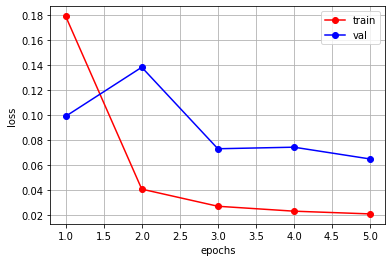

In [25]:
# --------------- 학습 모델의 테스트 결과를 그래프로 나타내는 과정입니다. ------------
# 훈련, 검증 loss 그래프
epochs = range(1, 6)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.grid(True)
plt.show()
# --------------- 학습 모델의 테스트 결과를 그래프로 나타내는 과정입니다. ------------

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1083808   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,085,921
Trainable params: 1,085,921
Non-trainable params: 0
_________________________________________________________________
